# Visualizing Optimizers

Our goal is to understand how "learning" happens by implementing and visualizing model parameters using the following optimizers:

- Random Search.
- Batch Gradient Descent.
- Stochastic Gradient Descent.
- Momentum.

In [1]:
%matplotlib widget

In [2]:
import random
from math import sqrt
from pathlib import Path
from random import sample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression
from ipywidgets import interactive

np.random.seed(42)
random.seed(42)

Let's set the datastore and get the files of interest:

In [3]:
# Set the data store path 
data_store = Path("./data")
assert data_store.exists()

# Set the data files
gdp_file = data_store / "gdp_per_capita.csv"
happiness_file = data_store / "oecd.csv"
assert gdp_file.exists() and happiness_file.exists()

# Data Preparation

Let's read the GDP data:

In [4]:
gdp = pd.read_csv(
    gdp_file,
    sep="\t",
    encoding="latin1",
    thousands=",",
    na_values="n/a"
).dropna()
gdp.head()

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
3,Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
4,Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


.. and we read the OECD data:

In [5]:
# Read the file
oecd = pd.read_csv(
    happiness_file,
    thousands=","
)

# Select the columns of interest
cols = ["Country", "Indicator", "Measure", "Inequality", "Unit", "PowerCode", "Value"]
oecd = oecd[cols]
oecd.head()

,Country,Indicator,Measure,Inequality,Unit,PowerCode,Value
0,Australia,Labour market insecurity,Value,Total,Percentage,Units,5.4
1,Austria,Labour market insecurity,Value,Total,Percentage,Units,3.5
2,Belgium,Labour market insecurity,Value,Total,Percentage,Units,3.7
3,Canada,Labour market insecurity,Value,Total,Percentage,Units,6.0
4,Czech Republic,Labour market insecurity,Value,Total,Percentage,Units,3.1


We are interested in the `Life satisfaction` indicator and we only want to keep its values per country:

In [6]:
# Select the rows and columns of interest
cols = ["Country", "Value"]
oecd = oecd.loc[oecd["Indicator"] == "Life satisfaction", cols]

# Rename the columns
oecd = oecd.rename(columns={"Value": "satisfaction"})
oecd.head()

,Country,satisfaction
1812,Australia,7.3
1813,Austria,7.1
1814,Belgium,6.9
1815,Canada,7.4
1816,Czech Republic,6.7


In the same fashion, we are going to select the columns of interest and remove outliers from the GDP information:

In [7]:
# Get countries and GDP estimates
gdp = gdp[["Country", "2015"]]
gdp = gdp.rename(columns={"2015": "gdp"})

# Remove GDP outliers
gdp = gdp[gdp["gdp"] <= 60_000]
gdp.head()

,Country,gdp
0,Afghanistan,599.994
1,Albania,3995.383
2,Algeria,4318.135
3,Angola,4100.315
4,Antigua and Barbuda,14414.302


Let's join both dataframes together by `country` to estimate the relationship between GDP and life satisfaction:

In [8]:
df = pd.merge(left=gdp, right=oecd, on="Country")
df.shape

(152, 3)

Since we have multiple estimates per country, let's group by country and average them:

In [9]:
df = df.groupby("Country", as_index=False).mean()
df.head()

,Country,gdp,satisfaction
0,Australia,50961.865,7.350
1,Austria,43724.031,7.225
2,Belgium,40106.632,7.000
3,Brazil,8669.998,6.400
4,Canada,43331.961,7.425


Next, let's extract the GDP and satisfaction numbers and visualize them:

In [10]:
# Get the inputs (GDP) and outputs (Life satisfaction)
X = df["gdp"].values.reshape(-1, 1)
y = df["satisfaction"].values.reshape(-1, 1)
X.shape, y.shape

((37, 1), (37, 1))

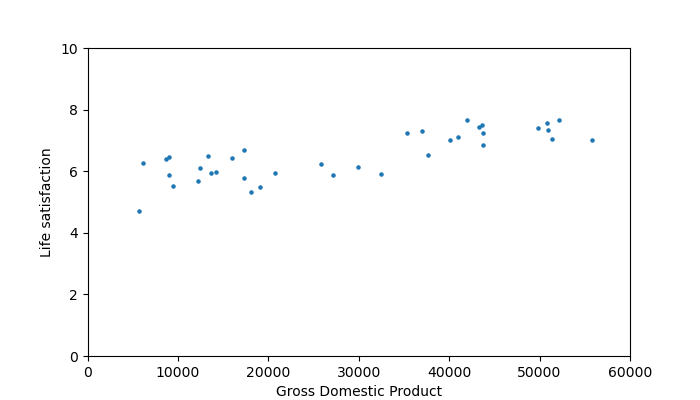

In [11]:
# Visualize
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(x=X, y=y, s=5)
ax.set_xlim((0, 60_000))
ax.set_ylim((0, 10))
ax.set_xlabel("Gross Domestic Product")
ax.set_ylabel("Life satisfaction")
plt.show()

# Implementing Linear Regression

Next, we will use an off-the-shelf algorithm to learn the above pattern, specifically, good-old `sklearn.linear_model.LienarRegression`: 

In [12]:
# Select the linear model
model = LinearRegression()

# Train the model (estimate the slope and intercept)
model.fit(X, y)

LinearRegression()

What weights did the linear regression model "learn":

In [13]:
model.coef_[0][0], model.intercept_[0]

(3.7628154906868684e-05, 5.441183567496472)

Let's visualize model predictions: 

In [14]:
# Note: because we are using a simple `f(x)=ax+b` model, we can just predict two points to infer all others
X_val = [[7_000], [55_000]]
y_val_hat = model.predict(X_val)

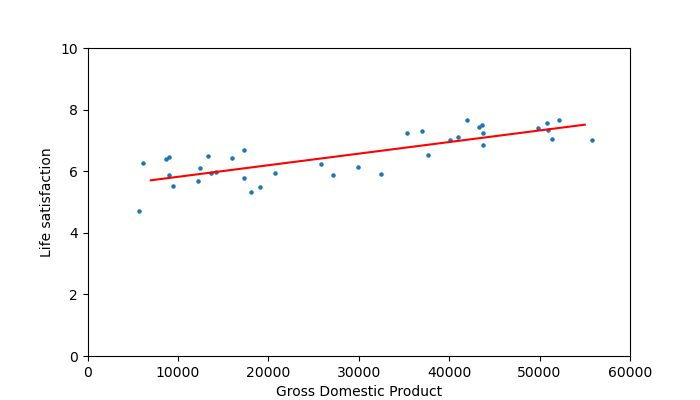

In [15]:
# Visualize
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(x=X, y=y, s=5)
ax.plot(X_val, y_val_hat, color="red")
ax.set_xlim((0, 60_000))
ax.set_ylim((0, 10))
ax.set_xlabel("Gross Domestic Product")
ax.set_ylabel("Life satisfaction")
plt.show()

The model seems to be doing fine.

Next, we want to understand how it managed to fit the points so we can reproduce the data-driven algorithm.
- We denote the inputs as $X$.
- We denote the outputs as $y$.
- We want to figure out the weights $w$ such that:

$$y = Xw$$

Given a matrix $\mathbf{X} \in \mathbb{R}^{M \times N}$ and a target vector $\mathbf{y} \in \mathbb{R}^{M}$, find a coefficient vector $\mathbf{w} \in \mathbb{R}^{N}$ that minimizes the squared error between the predicted values $\hat{\mathbf{y}} = \mathbf{X} \mathbf{w}$ and the actual values $\mathbf{y}$:

$$\min_{\mathbf{w} \in \mathbb{R}^{N}} | \mathbf{y} - \mathbf{X} \mathbf{w} |_{2}^{2}$$

where $|\cdot|_{2}$ denotes the L2 norm (i.e., Euclidean norm) of a vector.

 To derive the solution to the least-squares optimization problem, we can take the derivative of the objective function with respect to $\mathbf{w}$, set it equal to zero, and solve for $\mathbf{w}$. Here's how the derivation goes:

\begin{align*}
| \mathbf{y} - \mathbf{X} \mathbf{w} |_{2}^{2} &= (\mathbf{y} - \mathbf{X} \mathbf{w})^T (\mathbf{y} - \mathbf{X} \mathbf{w}) \
&= \mathbf{y}^T \mathbf{y} - 2 \mathbf{w}^T \mathbf{X}^T \mathbf{y} + \mathbf{w}^T \mathbf{X}^T \mathbf{X} \mathbf{w} \
\end{align*}

Taking the derivative of this expression with respect to $\mathbf{w}$ and setting it equal to zero gives:

\begin{align*}
\frac{\partial}{\partial \mathbf{w}} | \mathbf{y} - \mathbf{X} \mathbf{w} |_{2}^{2} &= -2 \mathbf{X}^T \mathbf{y} + 2 \mathbf{X}^T \mathbf{X} \mathbf{w} = \mathbf{0} \
\Rightarrow \quad \mathbf{X}^T \mathbf{X} \mathbf{w} &= \mathbf{X}^T \mathbf{y}
\end{align*}

Assuming that $\mathbf{X}^T \mathbf{X}$ is invertible (i.e., has full rank), we can solve for $\mathbf{w}$:

\begin{align*}
\mathbf{X}^T \mathbf{X} \mathbf{w} &= \mathbf{X}^T \mathbf{y} \
\Rightarrow \quad \mathbf{w} &= (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
\end{align*}

This expression gives us the optimal coefficient vector $\mathbf{w}$ that minimizes the squared error between the predicted values $\hat{\mathbf{y}} = \mathbf{X} \mathbf{w}$ and the actual values $\mathbf{y}$.

### General Tips for High-dimensional Derivations

1. **Understand the dimensions**: Make sure you understand the dimensions of the vectors and matrices involved in the problem. For example, if you're taking the derivative of a vector with respect to a matrix, the resulting expression will be a matrix with the same dimensions as the original matrix.

2. **Use the chain rule**: When taking the derivative of a function involving matrices or vectors, use the chain rule to break it down into simpler parts. For example, if you have a function of the form $f(\mathbf{X}\mathbf{w})$, where $\mathbf{X}$ is a matrix and $\mathbf{w}$ is a vector, you can use the chain rule to write:

$$\frac{\partial}{\partial \mathbf{w}} f(\mathbf{X}\mathbf{w}) = \frac{\partial f}{\partial (\mathbf{X}\mathbf{w})} \frac{\partial (\mathbf{X}\mathbf{w})}{\partial \mathbf{w}} = \mathbf{X}^T \frac{\partial f}{\partial (\mathbf{X}\mathbf{w})}$$

Here, we've used the fact that $\frac{\partial (\mathbf{X}\mathbf{w})}{\partial \mathbf{w}} = \mathbf{X}^T$.

3. **Use the transpose**: When taking the derivative of a function involving matrices or vectors, it's often helpful to use the transpose to simplify the expression.

4. **Use index notation**: In high-dimensional linear algebra, it can be helpful to use index notation to keep track of the indices of the vectors and matrices involved. For example, you can write:

$$\frac{\partial}{\partial w_i} \sum_{j=1}^n X_{ij} w_j = X_{ii}$$

Here, we've used the fact that the derivative of a sum is equal to the sum of the derivatives, and the derivative of $w_j$ with respect to $w_i$ is $\delta_{ij}$ (the Kronecker delta).

Let's implement the above from scratch using our own learner class. The steps:

1. `Fit`: Center `X` and `y` and save `X_mu` and `y_mu`.
2. `Fit`: Add the first column of `1`s to solve for the bias too.
2. `Fit`: Calculate the solution directly: $w=(X^{T}X)^{-1}X^{T}y$ and save it.
3. `Predict`: Shift the input.
4. `Predict`: Add the `1`s.
5. `Predict`: Calculate the predictions like: `y=Xw` and return them.

In [16]:
class CustomLinearRegression:
    
    def __init__(self):
        self.X_mu = None
        self.y_mu = None
        self.w = None
    
    def shift(self, X, y=None):
        if not isinstance(self.X_mu, np.ndarray): self.X_mu = np.mean(X, axis=0)
        if isinstance(y, np.ndarray): 
            self.y_mu = self.y_mu if isinstance(self.y_mu, np.ndarray) else np.mean(y, axis=0)
            y = y - self.y_mu
        X = X - self.X_mu
        return X, y
    
    def add_bias_feature(self, arr):
        ones = np.ones((arr.shape[0], 1))
        return np.concatenate([arr, ones], axis=1)
    
    def fit(self, X, y):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray)
        X, y = self.shift(X, y)
        X = self.add_bias_feature(X)
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y
    
    def predict(self, X):
        assert isinstance(self.w, np.ndarray)
        X, _ = self.shift(X)
        X = self.add_bias_feature(X)
        return (X @ self.w) + self.y_mu
    
    @property
    def slope(self):
        assert isinstance(self.w, np.ndarray)
        return self.w[:-1]

    @property
    def bias(self): 
        assert isinstance(self.w, np.ndarray)
        return self.predict(np.zeros(len(self.w.shape) - 1)[None,...])[0][0]

Let's test the function on the data we have:

In [17]:
# Init our custom model
our_model = CustomLinearRegression()

# Fit it to the data
our_model.fit(X, y)

# Predict the missing points 
y_val_custom_hat = our_model.predict(X_val)

Let's compare our predictions to the original ones:

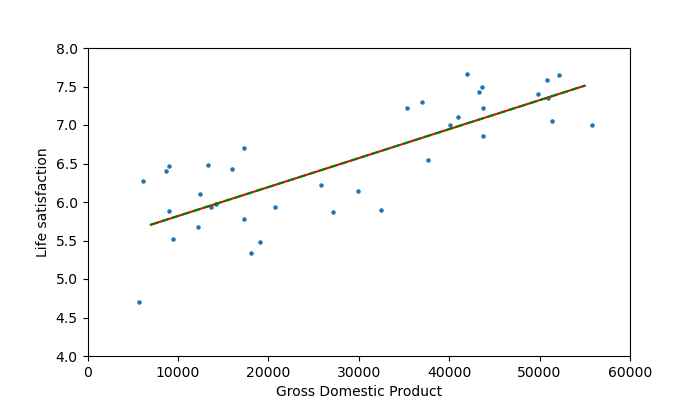

In [18]:
# Visualize
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(x=X, y=y, s=5)
ax.plot(X_val, y_val_hat, color="red")
ax.plot(X_val, y_val_custom_hat, color="green", linestyle="--")
ax.set_xlim((0, 60_000))
ax.set_ylim((4, 8))
ax.set_xlabel("Gross Domestic Product")
ax.set_ylabel("Life satisfaction")
plt.show()

Let's compare the derived coefficients:

In [19]:
print(f"sklearn model: Slope {round(model.coef_[0][0], 5)}. Bias {round(model.intercept_[0], 2)}")
print(f"Our model:     Slope {round(our_model.w[0][0], 5)}. Bias {round(our_model.bias, 2)}")

sklearn model: Slope 4e-05. Bias 5.44
Our model:     Slope 4e-05. Bias 5.44


We were able to mirror the learnt parameters from `sklearn.linear_model.LinearRegression`. Of course the `sklearn` module has other features such as `pre-process normalization`, other `solver` types that are more robust, and so on.

However, the core lesson here is that the learning process involves the following components:

- Data: `X` (inputs) and `y` (outputs).
- Model (`predictor`): for simple linear regression it is: `f(X) = w0 + X1w1 + ... + Xnwn`.
- Loss function: least sqaures $\mathcal{L}(y, X, w) = |y - Xw|_2^2$

Our goal is to find a set of weights that minimize the loss function and give us the best predictions possible.

For linear regression, the solution can be analytically derived to be unique because the loss function is convex:

To prove that the least squares function is convex, we need to show that its Hessian matrix is positive semi-definite for all points in its domain.

The least squares function can be written as:

$$f(\boldsymbol{w}) = \frac{1}{2}||\boldsymbol{y} - \boldsymbol{Xw}||_2^2$$

where $\boldsymbol{X} \in \mathbb{R}^{n \times m}$ is the design matrix, $\boldsymbol{w} \in \mathbb{R}^m$ is the weight vector, and $\boldsymbol{y} \in \mathbb{R}^n$ is the target vector.

The Hessian matrix of $f(\boldsymbol{w})$ is:

$$\nabla^2 f(\boldsymbol{w}) = \nabla(\nabla f(\boldsymbol{w})) = \nabla(\boldsymbol{X}^T \boldsymbol{X}) = \boldsymbol{X}^T \boldsymbol{X}$$

To show that $\boldsymbol{X}^T \boldsymbol{X}$ is positive semi-definite, we need to show that for any vector $\boldsymbol{v} \in \mathbb{R}^m$, $\boldsymbol{v}^T \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{v} \geq 0$.

We can rewrite $\boldsymbol{v}^T \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{v}$ as $(\boldsymbol{X} \boldsymbol{v})^T (\boldsymbol{X} \boldsymbol{v})$, which is the dot product of $\boldsymbol{X} \boldsymbol{v}$ with itself. Since the dot product of any vector with itself is always non-negative, we have:

$$(\boldsymbol{X} \boldsymbol{v})^T (\boldsymbol{X} \boldsymbol{v}) \geq 0$$

Therefore, $\boldsymbol{X}^T \boldsymbol{X}$ is positive semi-definite, and the least squares function is convex.

However, the majority of modern ML optimizers are stochastic because of the non-convexity of loss functions. For this reason, we will explore algorithms for finding the best weights using stochastic methods, with a focus on gradient-based methods.

To do this, let's start by plotting our points with the ability to change the parameters of the model manually: 

In [20]:
# Manually create the model
def plot_line(a, b):
    
    # Create the edges to be predicted
    X_val = [7_000, 55_000]
    y_val_hat = [X_val[0]*a + b, X_val[1]*a + b]
    
    # Plot
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(x=X, y=y, s=5)
    ax.plot(X_val, y_val_hat, color="red")
    ax.set_xlim((0, 60_000))
    ax.set_ylim((0, 10))
    ax.set_xlabel("Gross Domestic Product")
    ax.set_ylabel("Life satisfaction")
    plt.show()
    
# Use the interactive widget to create a slider that controls the frequency
interactive_plot = interactive(plot_line, a=(3e-05,5e-05, 1e-06), b=(0,10,.1))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(FloatSlider(value=3.9999999999999996e-05, description='a', max=5e-05, min=3e-05, step=1e…

We can use our intuition to select the best model. However, we can do better by adding the loss function estimate into the title of the figure to guide us:

In [21]:
def least_squares_loss(y, y_hat):
    return float(np.sum((y - y_hat)**2))

# Manually create the model
def plot_line(a, b):
    
    # Calculate the loss using `a` and `b`
    y_hat = X*a + b
    loss = least_squares_loss(y, y_hat)
    
    # Create the edges to be predicted
    X_val = [7_000, 55_000]
    y_val_hat = [X_val[0]*a + b, X_val[1]*a + b]
    
    # Plot
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(x=X, y=y, s=5)
    ax.plot(X_val, y_val_hat, color="red")
    ax.set_xlim((0, 60_000))
    ax.set_ylim((0, 10))
    ax.set_xlabel("Gross Domestic Product")
    ax.set_ylabel("Life satisfaction")
    ax.set_title(f"Loss: {round(loss, 4)}")
    plt.show()
    
# Use the interactive widget to create a slider that controls the frequency
interactive_plot = interactive(plot_line, a=(3e-05,5e-05, 1e-06), b=(0,10,.05))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(FloatSlider(value=3.9999999999999996e-05, description='a', max=5e-05, min=3e-05, step=1e…

We notice that we always optimize for one parameter before optimizing w.r.t the other.

To do better, let's plot the function everywhere for (`a` and `b`) and reach the mininmum manually:

In [22]:
def predict(a, b, X): return (X * a) + b

# Precompute: Estimate 2D loss
a_values = np.linspace(3e-05, 5e-05, 100)
b_values = np.linspace(0, 10, 500)
A, B = np.meshgrid(a_values, b_values)
L = np.zeros_like(A)
for i in range(len(a_values)):
    for j in range(len(b_values)):
        a_ = a_values[i]
        b_ = b_values[j]
        y_hat_ = predict(a_, b_, X)
        L[j,i] = least_squares_loss(y, y_hat_)

# Manually create the model
def plot_line(a, b):
    
    # Create the edges to be predicted
    X_val = np.array([7_000, 55_000])
    y_val_hat = predict(a, b, X_val)
    
    # Calculate the loss using `a` and `b`
    y_hat_ = predict(a, b, X)
    loss = least_squares_loss(y, y_hat_)
    
    # Init the axes
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*5, 1*5))
    
    # Plot the first figure 
    ax1.scatter(x=X, y=y, s=5)
    ax1.plot(X_val, y_val_hat, color="red")
    ax1.set_xlim((0, 60_000))
    ax1.set_ylim((0, 10))
    ax1.set_xlabel("Gross Domestic Product")
    ax1.set_ylabel("Life satisfaction")
    ax1.set_title(f"Loss: {round(loss, 4)}")
    
    # Plot the 3D plot on the second subplot
    ax2 = fig.add_subplot(122, projection="3d")
    ax2.plot_surface(A, B, L, cmap='coolwarm', alpha=.5)
    ax2.scatter(a, b, loss, s=50, c='r', marker='o')
    ax2.set_xlabel('a')
    ax2.set_ylabel('b')
    ax2.set_zlabel('Loss')
    ax2.set_title('3D Plot')
    ax2.set_box_aspect([1, 1, 0.5])
    
    # Show
    plt.show()
    
# Use the interactive widget to create a slider that controls the frequency
interactive_plot = interactive(plot_line, a=(3e-05, 5e-05, 1e-07), b=(0, 10, 0.1))
output = interactive_plot.children[-1]
output.layout.height = "650px"
interactive_plot

interactive(children=(FloatSlider(value=3.9999999999999996e-05, description='a', max=5e-05, min=3e-05, step=1e…

Let's experiment with other optimization algorithms:

- `Random search` 
    1. Start with initial weights (`a0`, `b0`) and radius eps
    2. Uniformely sample `batch_size` weight points from the domain of which the initial point is the center.
    3. Calculate the loss for each point. 
    4. Get the point where the loss is at a minimum.
    5. Go to step `1` where the center is the initial point and `eps <- eps / 2`.
    6. Stop when `abs(old_loss - new_loss) < alpha` (where alpha is pre-determined.  
- `Batch Gradient descent`
    0. Fix the learning rate and calculate the derivative of the loss function with respect to `a` and `b`.
    1. Start with randomly assigned initial weights.
    2. Conduct `W <- W - deriv(J)/(W)` for each parameter.
    3. Stop when `abs(new_loss - old_loss) < alpha`.
- `Stochastic Gradient Descent`: updates the model based on the gradient of the loss function with respect to the parameters. It uses a small batch of training examples to estimate the gradient.
- `Momentum`: adds a momentum term to the gradient updates to smooth out the updates and accelerate convergence. The momentum term accumulates the gradients of past updates and uses them to make larger updates in consistent directions.

# Random Search

Let's start by implementing `random search`, we implement the following components:

- `predict(a,b,w)`.
- `loss(y, y_hat)`.
- `sample(start, end, size)`
- `reduce(eps)`
- `plot_state(a, b)`.

In [23]:
def get_data(normalize=False): 
    X = df["gdp"].values.reshape(-1, 1)
    y = df["satisfaction"].values.reshape(-1, 1)
    if normalize:  
        X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)
        y = (y - y.mean()) / y.std()
    return X, y
def predict(X,a,b): return (a*X) + b
def loss(y, y_hat): return float(np.sum((y - y_hat) ** 2))
def sample_points(center, eps, size=10):
    a0, a1 = center[0] - eps[0], center[0] + eps[0]
    b0, b1 = center[1] - eps[1], center[1] + eps[1]
    a_values = np.random.uniform(a0, a1, size=size)
    b_values = np.random.uniform(b0, b1, size=size)
    A, B = np.meshgrid(a_values, b_values)
    A = A.reshape(-1, 1)
    B = B.reshape(-1, 1)
    return np.concatenate((A, B), axis=1)
def reduce(eps, factor=.9): return [float(e*factor) for e in eps]

Let's write the algorithm:

In [24]:
# Start somewhere
p = [0, 5]
eps = [1e-2, 5]
prev_loss = float("+inf")
ins, outs = get_data()
alpha = 1e-4
eps_reducer = 0.9
history = list()

# Search until you can't improve anymore
# .. and maybe plot :)
while True:
    
    # Sample the weights
    weights = sample_points(p, eps, size=100).tolist()
    
    # Init the list of local lorandoms
    losses = list()
    for a, b in weights: losses.append((a, b, loss(outs, predict(ins,a,b))))
    
    # Get the weights at the minimum loss
    best_a, best_b, new_loss = sorted(losses, key=lambda e: e[-1])[0]
    p = [best_a, best_b]
    print(f"The current best parameters: {p} with loss: {round(new_loss, 3)}")
    
    # Stop if we are not improving much
    if abs(prev_loss - new_loss) < alpha: break
        
    # Otherwise, reduce the search space
    prev_loss = new_loss
    eps = reduce(eps)
    
    # Store training history
    history.append((best_a, best_b, new_loss))

The current best parameters: [-9.64617977745963e-05, 9.246936182785628] with loss: 174.253
The current best parameters: [-4.899412188113744e-05, 7.950690290646983] with loss: 77.051
The current best parameters: [3.609431177414852e-05, 5.458231342997216] with loss: 7.411
The current best parameters: [1.3381572159803686e-05, 6.1554377620284] with loss: 12.837
The current best parameters: [4.2184497726368944e-05, 5.366099652013839] with loss: 7.667
The current best parameters: [-8.270456664087105e-05, 8.288480853958776] with loss: 154.537
The current best parameters: [-9.452218347402844e-05, 9.246287627818054] with loss: 169.481
The current best parameters: [-2.5314452119004773e-05, 7.234663507691938] with loss: 44.132
The current best parameters: [-3.2222166017102462e-06, 6.665410874927517] with loss: 22.975
The current best parameters: [4.21268467055786e-05, 5.30513124258804] with loss: 7.553
The current best parameters: [2.6872220978879095e-05, 5.72678308530711] with loss: 8.454
The cu

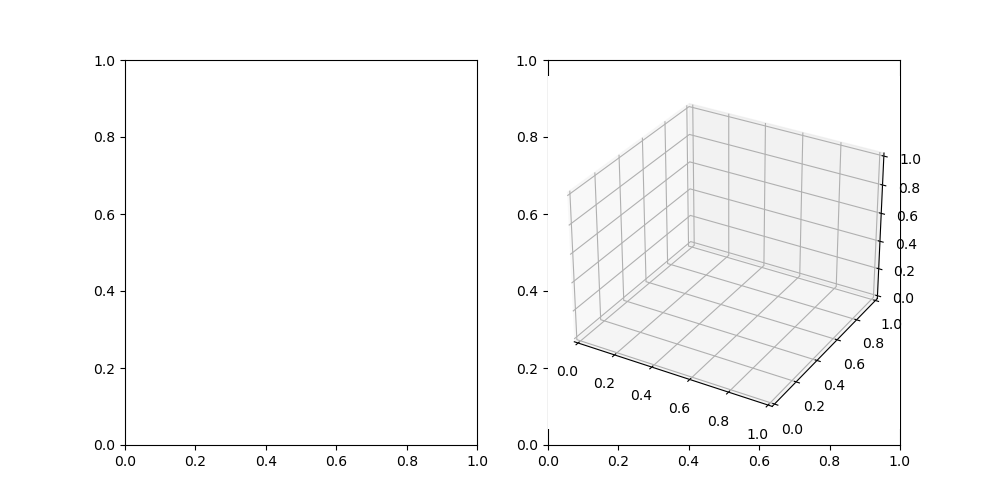

In [25]:
# Visualize
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*5, 1*5))
ax2 = fig.add_subplot(122, projection="3d")
    
def plot_state(frame):
    ax1.clear()
    ax2.clear()
    a, b, loss = history[frame]
    X_val = np.array([7_000, 55_000])
    y_val_hat = predict(X_val,a,b)
    scatter = ax1.scatter(x=X, y=y, s=5)
    line, = ax1.plot(X_val, y_val_hat, color="red")
    ax1.set_xlim((0, 60_000))
    ax1.set_ylim((0, 10))
    ax1.set_xlabel("Gross Domestic Product")
    ax1.set_ylabel("Life satisfaction")
    ax1.set_title(f"Loss: {round(loss, 4)}")
    ax2.plot_surface(A, B, L, cmap='coolwarm', alpha=.5)
    scatter_3d = ax2.scatter(a, b, loss, s=50, c='r', marker='o')
    ax2.set_xlabel('a')
    ax2.set_ylabel('b')
    ax2.set_zlabel('Loss')
    ax2.set_title('3D Plot')
    ax2.set_box_aspect([1, 1, 0.5])
    return scatter, line, scatter_3d

# create the animation object
ani = animation.FuncAnimation(fig, plot_state, frames=len(history), interval=5, blit=True, repeat=False)

# Show the plot
plt.show()

While the above approach works well in low dimensional spaces, the search space grows exponentially with the number of dimensions. We would require a lot of time to find the optimal solution in N-dimensional spaces.

Let's demonstrate this issue by...

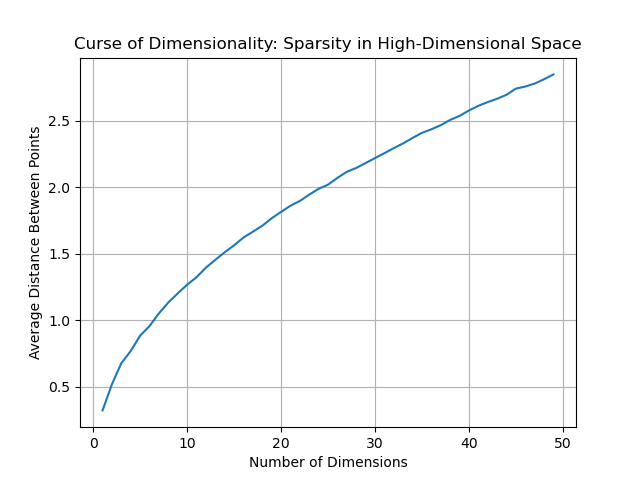

In [26]:
# Utility functions
def generate_random_points(n_points, n_dims): return np.random.rand(n_points, n_dims)
def euclidean_distance(a, b): return np.sqrt(np.sum((a - b)**2, axis=1))
def average_distance(n_points, n_dims):
    points = generate_random_points(n_points, n_dims)
    avg_distances = []
    for i in range(n_points):
        other_points = np.delete(points, i, axis=0)
        distances = euclidean_distance(points[i], other_points)
        avg_distances.append(np.mean(distances))
    return np.mean(avg_distances)

# Number of points to sample and number of dimensions to test
n_points = 1000
dimensions = range(1, 50)

# Calculate the average distance between any two points in the space
avg_distances = [average_distance(n_points, n_dims) for n_dims in dimensions]

# Visualize the relationship between the number of dimensions & the average distance between weight-points
fig, ax = plt.subplots()
ax.plot(dimensions, avg_distances)
ax.set_xlabel('Number of Dimensions')
ax.set_ylabel('Average Distance Between Points')
ax.set_title('Curse of Dimensionality: Sparsity in High-Dimensional Space')
ax.grid()
plt.show()

# Gradient Descent

The second problem that we want to highlight is the time needed to converge compared to using **guided-learning**.

Let's study gradient-based optimization algorithms to get a feeling of how they work. Notes:

- The gradient of a function characterizes how `y` changes if we change `x` a little bit.
- If you move the parameter in the direction of the gradient, `y` will increase locally.
- We want to minimize `Loss=y`, thus, we will move in the **opposite direction** of the given derivative.
- In a way, the gradient is taking on the previous responsibility of samplign a bunch of points to know which direction should we move. 

More formally:
1. Initialize the parameters $\theta$ to random values.
2. Calculate the cost function $J(\theta)$ using the current values of $\theta$.
3. Calculate the partial derivative of the cost function with respect to each parameter $\theta_{j}$.
4. Update each parameter using the update rule $\theta_{j} := \theta_{j} - \alpha\frac{\partial}{\partial \theta_{j}} J(\theta)$.
5. Repeat steps 2-4 until convergence (i.e., until the cost function stops decreasing).

Given a cost function $J(\theta)$ and a learning rate $\alpha$, we want to find the values of the parameters $\theta$ that minimize the cost function. We can use gradient descent to iteratively update the parameters until we converge to the minimum.

The update rule for gradient descent is:

$$\theta_{j} := \theta_{j} - \alpha\frac{\partial}{\partial \theta_{j}} J(\theta)$$

where $\theta_{j}$ is the $j$-th parameter, $\frac{\partial}{\partial \theta_{j}} J(\theta)$ is the partial derivative of the cost function with respect to $\theta_{j}$, and $\alpha$ is the learning rate.

We repeat this update rule for all parameters until convergence:

$$\theta_{0} := \theta_{0} - \alpha\frac{\partial}{\partial \theta_{0}} J(\theta)$$

$$\theta_{1} := \theta_{1} - \alpha\frac{\partial}{\partial \theta_{1}} J(\theta)$$

$$\vdots$$

$$\theta_{n} := \theta_{n} - \alpha\frac{\partial}{\partial \theta_{n}} J(\theta)$$

where $n$ is the number of parameters.

Now, we can pre-calculate the derivatives of the loss function w.r.t. `a` and `b`:

The least squares loss function for a linear regression model f(x) = ax + b is given by:

$$ J(a,b) = \frac{1}{2n}\sum_{i=1}^{n}(f(x_{i}) - y_{i})^2 $$

where $n$ is the number of data points, $x_i$ and $y_i$ are the $i$-th input and target output, and $f(x_i) = ax_i + b$.

To calculate the partial derivative of the loss function with respect to the slope a, we can use the chain rule:

$$ \frac{\partial J}{\partial a} = \frac{1}{n}\sum_{i=1}^{n}(f(x_{i}) - y_{i})\frac{\partial f(x_{i})}{\partial a} $$

$$ = \frac{1}{n}\sum_{i=1}^{n}(f(x_{i}) - y_{i})x_{i} $$

To calculate the partial derivative of the loss function with respect to the intercept b, we can similarly use the chain rule:

$$ \frac{\partial J}{\partial b} = \frac{1}{n}\sum_{i=1}^{n}(f(x_{i}) - y_{i})\frac{\partial f(x_{i})}{\partial b} $$

$$ = \frac{1}{n}\sum_{i=1}^{n}(f(x_{i}) - y_{i}) $$

Therefore, the partial derivatives of the least squares loss function with respect to the slope a and intercept b for a linear regression model f(x) = ax + b are:

$$ \frac{\partial J}{\partial a} = \frac{1}{n}\sum_{i=1}^{n}(f(x_{i}) - y_{i})x_{i} $$

$$ \frac{\partial J}{\partial b} = \frac{1}{n}\sum_{i=1}^{n}(f(x_{i}) - y_{i}) $$

These partial derivatives are used in the gradient descent algorithm to update the values of a and b iteratively to minimize the loss function.

Let's implement the algorithm:

- Learning rate determination is difficult with data that has multiple ranges, for this reason we are going to:
    - Standardize `X`.
    - Standardize `y`.

In [27]:
# Start somewhere
a, b = 0.9, 7.3
lr = .1
prev_loss = float("+inf")
ins, outs = get_data(normalize=True)
alpha = 1e-4
history = list()
n_points = ins.shape[0]

# Search until you can't improve anymore
while True:
    
    # Calculate the new loss
    y_hat_ = predict(ins, a, b)
    new_loss = loss(outs, y_hat_)
    
    # Update the parameters
    a = a - lr*(1/n_points)*(np.sum((y_hat_ - outs)*ins))
    b = b - lr*(1/n_points)*(np.sum(y_hat_ - outs))
    
    # Save to history
    history.append((a, b, new_loss))
    
    # if we are improving much, we break
    if abs(prev_loss - new_loss) < alpha: break
    
    # Update the previous loss
    prev_loss = new_loss
        
    # Get the weights at the minimum loss
    print(f"The current best parameters: {round(a, 2)},{round(b, 2)} with loss: {round(new_loss, 3)}")

The current best parameters: 0.89,6.57 with loss: 1985.383
The current best parameters: 0.88,5.91 with loss: 1610.684
The current best parameters: 0.87,5.32 with loss: 1307.179
The current best parameters: 0.87,4.79 with loss: 1061.339
The current best parameters: 0.86,4.31 with loss: 862.209
The current best parameters: 0.85,3.88 with loss: 700.914
The current best parameters: 0.85,3.49 with loss: 570.265
The current best parameters: 0.84,3.14 with loss: 464.439
The current best parameters: 0.84,2.83 with loss: 378.72
The current best parameters: 0.84,2.55 with loss: 309.288
The current best parameters: 0.83,2.29 with loss: 253.048
The current best parameters: 0.83,2.06 with loss: 207.493
The current best parameters: 0.83,1.86 with loss: 170.594
The current best parameters: 0.82,1.67 with loss: 140.705
The current best parameters: 0.82,1.5 with loss: 116.496
The current best parameters: 0.82,1.35 with loss: 96.886
The current best parameters: 0.82,1.22 with loss: 81.002
The current be

Let's visualize the optimization process:

In [28]:
# Precompute: Estimate 2D loss
a_values = np.linspace(-3., +3., 100)
b_values = np.linspace(-3., +3., 100)
A, B = np.meshgrid(a_values, b_values)
L = np.zeros_like(A)
for i in range(len(a_values)):
    for j in range(len(b_values)):
        a_ = a_values[i]
        b_ = b_values[j]
        y_hat_ = predict(ins, a_, b_)
        L[j,i] = least_squares_loss(outs, y_hat_)

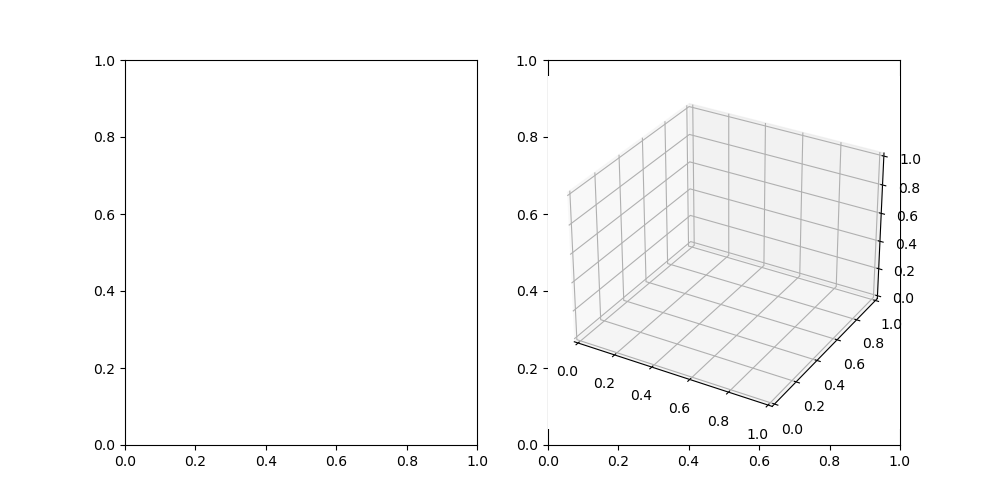

In [29]:
# clear and reset the whole plot
plt.clf()
plt.close()

# Visualize
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*5, 1*5))
ax2 = fig.add_subplot(122, projection="3d")

# Init stuff
X_val = np.array([-2, +2])

def plot_state(frame):
    ax1.clear()
    ax2.clear()
    a, b, loss = history[frame]
    y_val_hat = predict(X_val, a, b)
    scatter = ax1.scatter(x=ins, y=outs, s=5)
    line, = ax1.plot(X_val, y_val_hat, color="red")
    ax1.set_title(f"Loss: {round(loss, 4)}")
    ax1.set_xlim((-3, +3))
    ax1.set_ylim((-3, +3))
    ax1.set_xlabel("Gross Domestic Product")
    ax1.set_ylabel("Life satisfaction")
    ax2.plot_surface(A, B, L, cmap='coolwarm', alpha=.33)
    ax2.set_xlabel('a')
    ax2.set_ylabel('b')
    ax2.set_zlabel('Loss')
    ax2.set_title('3D Plot')
    ax2.set_box_aspect([1, 1, 0.5])
    scatter_3d = ax2.scatter(a, b, loss, s=50, c='r', marker='o')
    return line, scatter_3d, line

# create the animation object
ani = animation.FuncAnimation(fig, plot_state, frames=len(history), interval=100, repeat=False)

# Show the plot
plt.show()

The only difference between the above algorithm and stochastic gradient decsent is in the sample size we use to calculate the gradient:

- Batch gradient descent: we use the whole data set to get an accurate estimate of the gradient at parameter points `(a, b)`.
- Stochastic gradient descent: we use a mini-batch (its size is up to us), to estimate the gradient. Characteristics:
    - `Noisy`: the gradient is less accurate.
    - `Regularization`: introducing noise to the gradient keeps pattern signal and eliminates the signal that typically leads to overfitting.
    - `Efficiency`: we don't have to load all data points into memory to estimate the gradient. We can imagine this being an issue when we have images/videos as data points.

# Stochastic gradient descent

Let's implement stochastic gradient descent with a mini-batch size of `5` points:

In [30]:
# Start somewhere
a, b = 0.9, 7.3
lr = .1
ins, outs = get_data(normalize=True)
history = list()
mini_batch = 10
iterations = 100

# Search until you can't improve anymore
for _ in range(iterations):
    
    # Sample mini-batch data points for the gradient descent step
    ids = sample(range(ins.shape[0]), mini_batch)
    
    # Get the ins & outs
    ins_ = ins[ids]
    outs_ = outs[ids]
    
    # Calculate the new loss
    y_hat_ = predict(ins_, a, b)
    new_loss = loss(outs_, y_hat_)
    
    # Update the parameters
    a -= lr*(1/mini_batch)*(np.sum((y_hat_ - outs_)*ins_))
    b -= lr*(1/mini_batch)*(np.sum(y_hat_ - outs_))
    
    # Save to history
    history.append((a, b, new_loss))
    
    # Get the weights at the minimum loss
    print(f"The current best parameters: {round(a, 2)},{round(b, 2)} with loss: {round(new_loss, 3)}")

The current best parameters: 0.98,6.6 with loss: 485.814
The current best parameters: 0.98,5.94 with loss: 446.284
The current best parameters: 0.92,5.34 with loss: 361.513
The current best parameters: 0.92,4.83 with loss: 267.416
The current best parameters: 0.9,4.38 with loss: 205.471
The current best parameters: 1.08,3.97 with loss: 167.827
The current best parameters: 1.03,3.57 with loss: 163.53
The current best parameters: 1.01,3.22 with loss: 129.497
The current best parameters: 0.9,2.9 with loss: 102.63
The current best parameters: 0.74,2.61 with loss: 85.95
The current best parameters: 0.89,2.33 with loss: 86.941
The current best parameters: 0.79,2.07 with loss: 67.894
The current best parameters: 0.84,1.85 with loss: 52.279
The current best parameters: 0.73,1.68 with loss: 31.754
The current best parameters: 0.8,1.51 with loss: 33.45
The current best parameters: 0.82,1.33 with loss: 33.458
The current best parameters: 0.78,1.18 with loss: 26.916
The current best parameters: 0.

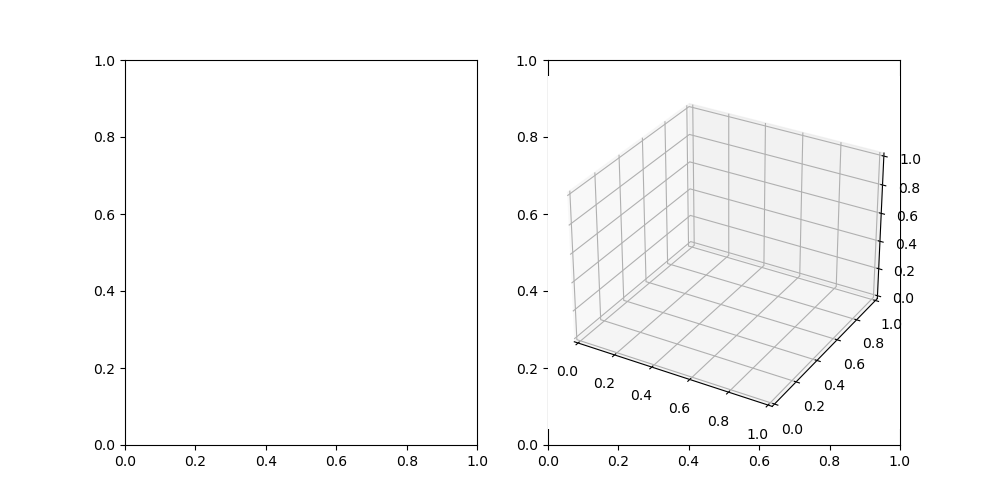

In [31]:
# clear and reset the whole plot
plt.clf()
plt.close()

# Visualize
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*5, 1*5))
ax2 = fig.add_subplot(122, projection="3d")

# Init stuff
X_val = np.array([-2, +2])

def plot_state(frame):
    ax1.clear()
    ax2.clear()
    a, b, loss = history[frame]
    y_val_hat = predict(X_val, a, b)
    scatter = ax1.scatter(x=ins, y=outs, s=5)
    line, = ax1.plot(X_val, y_val_hat, color="red")
    ax1.set_title(f"Loss: {round(loss, 4)}")
    ax1.set_xlim((-3, +3))
    ax1.set_ylim((-3, +3))
    ax1.set_xlabel("Gross Domestic Product")
    ax1.set_ylabel("Life satisfaction")
    ax2.plot_surface(A, B, L, cmap='coolwarm', alpha=.33)
    ax2.set_xlabel('a')
    ax2.set_ylabel('b')
    ax2.set_zlabel('Loss')
    ax2.set_title('3D Plot')
    ax2.set_box_aspect([1, 1, 0.5])
    scatter_3d = ax2.scatter(a, b, loss, s=50, c='r', marker='o')
    return line, scatter_3d, line

# create the animation object
ani = animation.FuncAnimation(fig, plot_state, frames=len(history), interval=100, repeat=False)

# Show the plot
plt.show()

# Momentum SGD

Next, we will implement stochastic gradient decsent with momentum:

<div style="text-align:center;">
    <img style="width:33%;" src="static/momentum_comparison.png" />
</div>

The update rule for SGD with momentum is:

$$
v_{t} = \beta v_{t-1} + (1 - \beta)\nabla_{\theta}J(\theta_{t-1}) \\
\theta_{t} = \theta_{t-1} - \alpha v_{t}
$$
 
- $t$ is the current iteration
- $\theta_t$ is the parameter vector at iteration $t$
- $v_t$ is the velocity vector at iteration $t$
- $\alpha$ is the learning rate
- $\beta$ is the momentum coefficient
- $\nabla_{\theta} J(\theta_{t-1})$ is the gradient of the loss function $J(\theta)$ with respect to the parameters $\theta$ evaluated at iteration $t-1$.

The momentum update rule consists of two parts
1. $\beta v_{t-1}$ is scaled by the momentum coefficient $\beta$.
2. $(1 - \beta) \nabla_{\theta} J(\theta_{t-1})$ is scaled by $(1 - \beta)$, which reduces the influence of the previous velocity vector and gives more weight to the current gradient estimate. 
3. The velocity vector $v_t$ is updated by summing the previous velocity vector and the current gradient estimate.

Let's implement SGD with momentum:

In [32]:
# Start somewhere
a, b = 0.9, 7.3
lr = .5
beta = .9
ins, outs = get_data(normalize=True)
history = list()
mini_batch = 10
iterations = 100
avs = list()
bvs = list()

# Search until you can't improve anymore
for _ in range(iterations):
    
    # Sample mini-batch data points for the gradient descent step
    ids = sample(range(ins.shape[0]), mini_batch)
    
    # Get the ins & outs
    ins_ = ins[ids]
    outs_ = outs[ids]
    
    # Calculate the new loss
    y_hat_ = predict(ins_, a, b)
    new_loss = loss(outs_, y_hat_)
    
    # Calculate the derivatives
    da = (1/mini_batch)*(np.sum((y_hat_ - outs_)*ins_))
    db = lr*(1/mini_batch)*(np.sum(y_hat_ - outs_))
    
    # create the `v` terms only if the `vs` list is not empty
    if avs and bvs:
        av = beta*avs[-1] + (1 - beta)*da
        bv = beta*bvs[-1] + (1 - beta)*db
    else:
        av, bv = da, db
    
    # Save the terms before updating
    avs.append(av)
    bvs.append(bv)
    
    # Update the parameters
    a -= lr*av
    b -= lr*bv
    
    # Save to history
    history.append((a, b, new_loss))
    
    # Get the weights at the minimum loss
    print(f"The current best parameters: {round(a, 2)},{round(b, 2)} with loss: {round(new_loss, 3)}")

The current best parameters: 0.34,5.47 with loss: 537.061
The current best parameters: 0.04,3.68 with loss: 346.066
The current best parameters: -0.22,1.98 with loss: 148.246
The current best parameters: -0.33,0.39 with loss: 78.61
The current best parameters: -0.38,-1.04 with loss: 13.704
The current best parameters: -0.34,-2.28 with loss: 45.555
The current best parameters: -0.21,-3.35 with loss: 70.812
The current best parameters: -0.13,-4.23 with loss: 92.499
The current best parameters: 0.01,-4.92 with loss: 206.151
The current best parameters: 0.31,-5.41 with loss: 268.618
The current best parameters: 0.59,-5.72 with loss: 298.111
The current best parameters: 0.9,-5.85 with loss: 324.285
The current best parameters: 1.17,-5.83 with loss: 327.342
The current best parameters: 1.29,-5.66 with loss: 355.928
The current best parameters: 1.32,-5.37 with loss: 341.933
The current best parameters: 1.36,-4.97 with loss: 305.773
The current best parameters: 1.33,-4.48 with loss: 256.115
Th

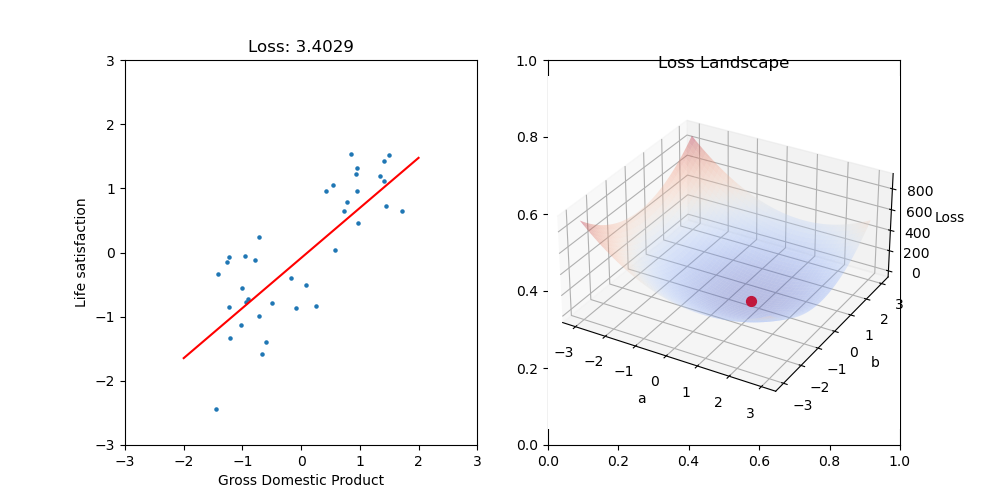

In [36]:
# clear and reset the whole plot
plt.clf()
plt.close()

# Visualize
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*5, 1*5))
ax2 = fig.add_subplot(122, projection="3d")

# Init stuff
X_val = np.array([-2, +2])

def plot_state(frame):
    ax1.clear()
    ax2.clear()
    a, b, loss = history[frame]
    y_val_hat = predict(X_val, a, b)
    scatter = ax1.scatter(x=ins, y=outs, s=5)
    line, = ax1.plot(X_val, y_val_hat, color="red")
    ax1.set_title(f"Loss: {round(loss, 4)}")
    ax1.set_xlim((-3, +3))
    ax1.set_ylim((-3, +3))
    ax1.set_xlabel("Gross Domestic Product")
    ax1.set_ylabel("Life satisfaction")
    ax2.plot_surface(A, B, L, cmap='coolwarm', alpha=.33)
    ax2.set_xlabel('a')
    ax2.set_ylabel('b')
    ax2.set_zlabel('Loss')
    ax2.set_title('Loss Landscape')
    ax2.set_box_aspect([1, 1, 0.5])
    scatter_3d = ax2.scatter(a, b, loss, s=50, c='r', marker='o')
    return line, scatter_3d, line

# create the animation object
ani = animation.FuncAnimation(fig, plot_state, frames=len(history), interval=100, repeat=False)

# # Save the animation
# ani.save('static/SGD_momentum.mp4', writer='ffmpeg')

# Show the plot
plt.show()

# Exercices

Attempt to implement and visualize these optimizers (refer to [this paper](https://arxiv.org/pdf/1609.04747.pdf) for detailed explanations for each algorithm):

- `AdaGrad`: adapts the `lr` for each parameter by dividing the `lr` by a running sum of the squared gradients for each parameter, which reduces the learning rate for frequently updated parameters and increases it for infrequently updated ones.
- `RMSProp`: This optimization algorithm is similar to `AdaGrad`, but it uses a moving average of the squared gradients to adapt the learning rate for each parameter.
- `Adam`: combines the ideas of momentum and adaptive `lr`. It uses a moving average of the gradients and a moving average of the squared gradients to adapt the learning rate for each parameter. 
    - It also includes bias correction terms to account for the initial estimates of the moving averages being biased towards zero.

---